# Classificador baseado no Grafo de Gabriel

## Parte 1 - Implementar o Classificador baseado em Grafo de Gabriel

Etapas:

1. Obter o Grafo de Gabriel a partir do conjunto de treinamento.
2. Eliminar a sobreposição de dados: para cada vértice do grafo verifica se a maioria
dos vértices vizinhos pertence à classe oposta. Caso afirmativo este vértice é considerado um ruído e eliminado do grafo.
3. Selecionar os vetores geométricos de suporte: seleção das arestas que possuem vértices de classes opostas.
4. Determinar os pontos médios de cada aresta.
5. Para cada par de vértices determinar as gaussianas centradas nos vértices.
6. Calcular as misturas de gaussianas para cada classe.
7. Implementar a regra de decisão bayesiana.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.neighbors import DistanceMetric
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn import preprocessing
import math
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Code adapted from https://github.com/cran/GGClassification/blob/master/src/GGClassification_gabriel_graph.cpp
# References for this method can be found in L.C.B. Torres et al. (2015) <doi:10.1049/el.2015.1644>
# and Enhancing Performance of Gabriel Graph-Based Classifiers by a Hardware Co-Processor for Embedded System Applications
def gabrielgraph(X):
    n = len(X)
    fourth_power_distance_array = np.zeros((n,n))
    for i in range(n):
        fourth_power_distance_array[:,i] = np.sum((X-X[i])**2,axis=1) # vectorized fourth power distance of col(i)
        fourth_power_distance_array[i,i] = np.inf # convention: distance between same point is infinity

    array_of_adjacency = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            min_sum_of_distances = np.min(fourth_power_distance_array[i,:] + fourth_power_distance_array[j,:])
            # if the sum of the minimum distances between other points to i and j isn't
            # less or equal to the distance between i and j, then (i,j) is an edge that belongs to the graph.
            if min_sum_of_distances >= fourth_power_distance_array[i,j]:
                array_of_adjacency[i,j] = 1
                array_of_adjacency[j,i] = 1
    return fourth_power_distance_array, array_of_adjacency

In [3]:
# Code based on from https://github.com/cran/GGClassification/
# References for this method can be found in L.C.B. Torres et al. (2015) <doi:10.1049/el.2015.1644>

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import multivariate_normal

def euclidean_pair_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

def euclidean_dist(X, x):
    return np.sqrt(np.sum((X-x)**2,axis=1))

class chip:
    def __init__(self, adj: np.ndarray = None) -> None:
        self.adj = adj

    def gg(self, X: np.ndarray) -> None:
        #gg_vec = GG_calculation(X)
        #self.adj = vec_to_adj(gg_vec, n=X.shape[0])
        _, self.adj = gabrielgraph(X)

    def build_pairs(self) -> None:
        pairs = np.transpose(np.array(np.where(self.adj==1)))
        all_neighbors = [[] for i in range(len(pairs))]
        for i in range(len(pairs)):
            all_neighbors[pairs[i,0]].append(pairs[i,1])

        all_neighbors = [np.unique(all_neighbors[i]) for i in range(len(all_neighbors))]
        self.all_neighbors = all_neighbors

        original_samples = []
        neighbors = []
        for i in range(len(self.adj)):
            n_neighbors = len(all_neighbors[i])
            original_samples.extend(np.repeat(i,n_neighbors))
            neighbors.extend(all_neighbors[i])
        hyper_pairs = np.c_[original_samples,neighbors]
        hyper_pairs = np.sort(hyper_pairs, axis=1)
        hyper_pairs = np.unique(hyper_pairs, axis=0)
        self.hyper_pairs = hyper_pairs
    
    def find_boundhyper(self, y: np.ndarray) -> None:
        bound_hyper = []
        for i in range(len(self.hyper_pairs)):
            if y[self.hyper_pairs[i][0]]!=y[self.hyper_pairs[i][1]]:
                bound_hyper.append(self.hyper_pairs[i].tolist())
        self.bound_hyper = bound_hyper

    '''
    This function receives the graph and its labels and filter the noise using an
    vertex quality rule. It returns an vector containing the indexes of the noisy data points.
  
    The quality of the vertex is the number of connections(degree) between same label vertexes
    and number of all connections of the vertex.
  
    The threshold that say if the vertex is an noise is the sum of all qualities of the vertexes
    belonging to the same class, divided by the length of the current class.
    ( this will give us two thresholds )
    '''
    def filter_chipclas(self, X: np.ndarray, y: np.ndarray) -> None:
        c = []
        for i in range(len(X)):
            #self.all_neighbors[i] = np.unique(self.all_neighbors[i])
            if y[i] == 1:
                c.append(np.sum(y[self.all_neighbors[i]]==1)/len(self.all_neighbors[i]))
            else:
                c.append(np.sum(y[self.all_neighbors[i]]!=1)/len(self.all_neighbors[i]))
        c = np.array(c)

        t1 = np.mean(c[y==1])
        t2 = np.mean(c[y!=1])

        valid_samples = []
        for i in range(len(X)):
            if(y[i]==1):
                if(c[i] >= t1):
                    valid_samples.append(1)
                else:
                    valid_samples.append(0)
            else:
                if(c[i] >= t2):
                    valid_samples.append(1)
                else:
                    valid_samples.append(0)
        self.valid_samples = valid_samples

    def fit(self, X: np.ndarray, y: np.ndarray, use_filter: bool = False) -> None:
        self.gg(X)
        self.build_pairs()
        if use_filter:
            self.filter_chipclas(X, y)
            valid_index = np.where(np.array(self.valid_samples)==1)[0]
            self.X_train = X[valid_index]
            self.y_train = y[valid_index]
            self.gg(self.X_train)
            self.build_pairs()
        else:
            self.X_train = X
            self.y_train = y
            self.valid_samples = np.ones(len(y))
        self.find_boundhyper(self.y_train)
        self.midpoints = []
        for i in range(len(self.bound_hyper)):
            self.midpoints.append((self.X_train[self.bound_hyper[i][0]]+self.X_train[self.bound_hyper[i][1]])/2)
            
    
    def predict(self, test_sample: np.ndarray) -> np.ndarray:
        bound_elements = [item for sublist in self.bound_hyper for item in sublist]
        bound_elements = list(set(bound_elements))
        X_bound=[]
        y_bound=[]
        nn = KNeighborsClassifier(n_neighbors=1)
        for i in range(len(bound_elements)):
            if(self.valid_samples[bound_elements[i]]==1):
                X_bound.append(self.X_train[bound_elements[i]])
                y_bound.append(self.y_train[bound_elements[i]])
        nn.fit(X=X_bound, y=y_bound),
        y_hat = nn.predict(test_sample)
        return y_hat  

## Parte 2 - Aplicação do Classifcador a um Problema Sintético

Etapas:

1. Carregar a base de dados.
2. Separar os dados em treinamento e teste.
3. Treinar e avaliar o classificador.
4. Plotar Grafo.
5. Plotar os dados no espaço de entrada resaltando os vetores geométricos de suporte.
6. Plotar os dados no espaço de entrada resaltando os pontos médios de cada aresta com vértices de classes opostas.
7. Plotar os dados no espaço de entrada com o hiperplano de separação.


### 1. Carregar a base de dados.

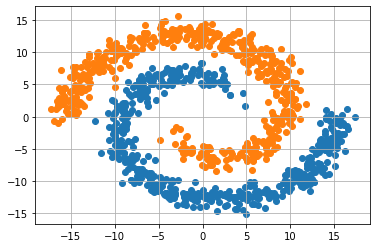

In [4]:
spirals_dataset = pd.read_csv('spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
y[y==2] = -1
col = ['blue', 'red']
for class_value in [-1, 1]:
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
plt.grid()

### 2. Separar os dados em treinamento e teste.

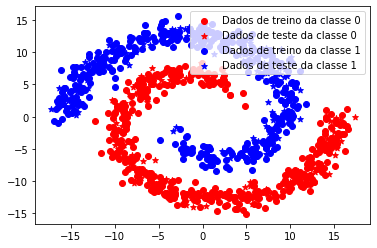

In [5]:
# Separate data between training and test:
y[y==-1] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create scatter of these samples
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    row_ix2 = np.where(y_test == class_value)
    colors = ["red", "blue"]
    labels_train = ["Dados de treino da classe 0", "Dados de treino da classe 1"]
    labels_test = ["Dados de teste da classe 0", "Dados de teste da classe 1"]
    # create scatter of these samples
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], color=colors[class_value], label=labels_train[class_value])
    plt.scatter(X_test[row_ix2, 0], X_test[row_ix2, 1], marker='*', color=colors[class_value], label=labels_test[class_value])
    plt.legend()
# show the plot
plt.show()

### 3. Treinar e avaliar o classificador.

In [6]:
chipclass = chip()
chipclass.fit(X_train, y_train, True)

In [7]:
y_hat = chipclass.predict(X_test)
print("Accuracy score: " + str(accuracy_score(y_test, y_hat)))

Accuracy score: 1.0


### 4. Plotar Grafo.

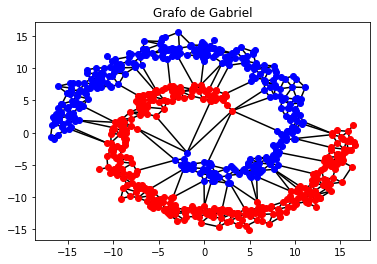

In [8]:
def plot_gabriel_graph(chipclass):
    X = chipclass.X_train
    y = chipclass.y_train
    pairs = chipclass.hyper_pairs 
    for pair in pairs:
        point1 = X[pair[0]]
        point2 = X[pair[1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, 'black', linestyle="-")
    col = "red"    
    for class_value in [0, 1]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.plot(X[row_ix, 0], X[row_ix, 1], marker='o', color=col)
        col = "blue"
        plt.grid()
        plt.title("Grafo de Gabriel")
    
plot_gabriel_graph(chipclass)

### 5. Plotar os dados no espaço de entrada resaltando os vetores geométricos de suporte.

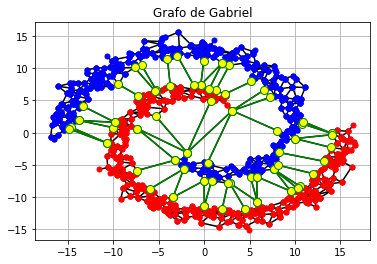

In [9]:
def plot_support_edges(chipclass):
    X = chipclass.X_train
    y = chipclass.y_train
    pairs = chipclass.hyper_pairs 
    bound_pairs = chipclass.bound_hyper
    
    for pair in pairs:
        point1 = X[pair[0]]
        point2 = X[pair[1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        class_ = [y[pair[0]], y[pair[1]]]
        plt.plot(x_values, y_values, color='black', linestyle='-', marker='', markersize=8)
        if class_[0] == class_[1] and class_[1] == 0:
            plt.plot(x_values, y_values, marker='o',  linestyle='', markersize=5, color='red')
        elif class_[0] == class_[1] and class_[1] == 1:
            plt.plot(x_values, y_values, marker='o',  linestyle='', markersize=5, color='blue')
        
    for pair in bound_pairs:
        point1 = X[pair[0]]
        point2 = X[pair[1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, color='green', linestyle='-', marker='o', markerfacecolor='yellow', markersize=8)
        plt.grid()
        plt.title("Grafo de Gabriel")
        
plot_support_edges(chipclass)

### 6. Plotar os dados no espaço de entrada resaltando os pontos médios de cada aresta com vértices de classes opostas.

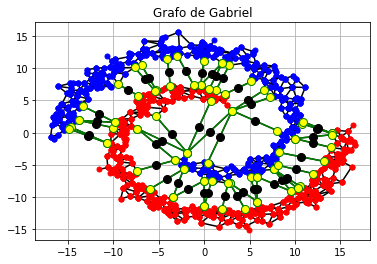

In [10]:
def plot_middle_points(chipclass):
    X = chipclass.X_train
    y = chipclass.y_train
    pairs = chipclass.hyper_pairs 
    bound_pairs = chipclass.bound_hyper
    
    for pair in pairs:
        point1 = X[pair[0]]
        point2 = X[pair[1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        class_ = [y[pair[0]], y[pair[1]]]
        plt.plot(x_values, y_values, color='black', linestyle='-', marker='', markersize=8)
        if class_[0] == class_[1] and class_[1] == 0:
            plt.plot(x_values, y_values, marker='o',  linestyle='', markersize=5, color='red')
        elif class_[0] == class_[1] and class_[1] == 1:
            plt.plot(x_values, y_values, marker='o',  linestyle='', markersize=5, color='blue')
        
    for i, pair in enumerate(bound_pairs):
        point1 = X[pair[0]]
        point2 = X[pair[1]]
        mid_point = chipclass.midpoints[i]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, color='green', linestyle='-', marker='o', markerfacecolor='yellow', markersize=8)
        plt.plot(mid_point[0], mid_point[1], color='black', linestyle='', marker='o', markerfacecolor='black', markersize=8)
        plt.grid()
        plt.title("Grafo de Gabriel")
plot_middle_points(chipclass)

### 7. Plotar os dados no espaço de entrada com o hiperplano de separação.

In [11]:
def plot_decision_border(X, y, clf):
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(121)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat=(clf.predict(grid))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in [0, 1]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    plt.grid()
    
    # plot surface:
    ax = fig.add_subplot(122, projection='3d')
    #create grid to evaluate model
    x = np.linspace(min1, max1, 30)
    y = np.linspace(min2, max2, 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = clf.predict(xy).reshape(X.shape)
    Z=np.array(Z).reshape(X.shape)
    # plot decision boundary and margins
    figure = ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap='RdBu',edgecolor='none')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()
    plt.show()
    #plt.show() 

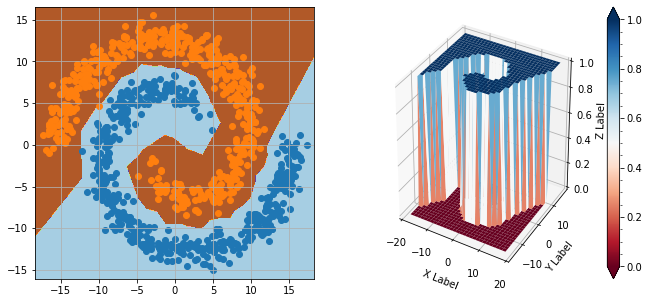

In [12]:
plot_decision_border(X, y, chipclass)

## Parte 3 - Aplicação do Classifcador a um Problema Real

O classificador será ser aplicado a um problema real de classificação de tipos de vidros do banco de dados Glass a partir de suas características químicas. Ele possui 214 instâncias de 10 atributos. Deverá ser mostrado a acurácia média e desvio padrão para 10 experimentos variando o conjunto de treinamento e teste.


In [13]:
# Loading dataset:
headers = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Class"]
df = pd.read_csv("~/Documents/UFMG/Graduation/10/Reconhecimento de padrões/list/pattern-recognition-exercises/list_5/databases/glass.csv", names = headers)
#df.columns = headers
df.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [14]:
from sklearn.preprocessing import StandardScaler
X = df.drop("Class", axis=1)
X = X.drop("Id", axis=1)
y = df["Class"]
normalizer = StandardScaler()
X = X.to_numpy()
y = y.to_numpy()
X = preprocessing.normalize(X, axis=0)

In [16]:
n_splits = 10
k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
acc = np.zeros(n_splits)
i = 0
for train_indices, test_indices in k_fold.split(X, y):
    clf = chip()
    clf.fit(X[train_indices], y[train_indices], False)
    y_pred = clf.predict(X[test_indices])
    acc[i] = accuracy_score(y[test_indices], y_pred)
    print("Acurácia para o fold " + str(i+1) + ": " + '{:.4f}'.format(acc[i]))
    i +=1
    
print("\nAcurácia Média: " + '{:.4f}'.format(acc.mean()) + "+/-" + '{:.4f}'.format(acc.std())) 

/home/vitor/-/.virtualenvs/k36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Acurácia para o fold 1: 0.7273
Acurácia para o fold 2: 0.6818
Acurácia para o fold 3: 0.6364
Acurácia para o fold 4: 0.6364
Acurácia para o fold 5: 0.7619
Acurácia para o fold 6: 0.6190
Acurácia para o fold 7: 0.7143
Acurácia para o fold 8: 0.8095
Acurácia para o fold 9: 0.6667
Acurácia para o fold 10: 0.6667

Acurácia Média: 0.6920+/-0.0577
